In [56]:
import torch 
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Resize, Compose, Normalize, CenterCrop
import torch.optim as optim

import matplotlib.pyplot as plt


torch.__version__

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device


device(type='cuda', index=0)

## Get data

Subset of Food101 Dataset (3) classes and 10% of data

75 training images per class and 25 testing images

In [10]:
from ast import With
from email.mime import image
import requests
import zipfile
from pathlib import Path

# Create data directory
data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'

if image_path.is_dir():
    print(f'{image_path} is already extracted')
else:
    print(f'Extracting {image_path}')
    image_path.mkdir(parents=True, exist_ok=True)

# Download the data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    r = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading...")
    f.write(r.content)

# Unzip the data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping...")
    zip_ref.extractall(image_path)

data\pizza_steak_sushi is already extracted
Downloading...
Unzipping...


### Becoming one with the Data (Data prep and exploration)

In [13]:
import os


def walk_through_dir(dir_path):
    
    '''
    Walks through dir_path returning its contents as a tuple (dirpath, dirnames, filenames)
    
    Args:
    dir_path (str): Path to directory
    
    Returns:
    None
    '''
    
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(image_path)

There are 2 directories and 0 images in 'data\pizza_steak_sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\test'.
There are 0 directories and 25 images in 'data\pizza_steak_sushi\test\pizza'.
There are 0 directories and 19 images in 'data\pizza_steak_sushi\test\steak'.
There are 0 directories and 31 images in 'data\pizza_steak_sushi\test\sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\train'.
There are 0 directories and 78 images in 'data\pizza_steak_sushi\train\pizza'.
There are 0 directories and 75 images in 'data\pizza_steak_sushi\train\steak'.
There are 0 directories and 72 images in 'data\pizza_steak_sushi\train\sushi'.


## Vizualing and Image for Preprocessing

Write code to: 
1. Get all image path
2. Pick a random image path using Python's `random.choice()`
3. Get the image class name using  `pathlib.Path.parent.stem`
4. Since I'm working with images, I'll use PIL (Python Image Library) 
5. Show image and print metadata

In [47]:
import random
from PIL import Image
from pathlib import Path


# Set seed
#random.seed(42)

# Get all image file paths
image_paths = list(image_path.glob("*/*/*.jpg"))

image_paths[-5:]

# Get class name from image path
random_image_path = random.choice(image_paths)
class_names = random_image_path.parent.stem
print(class_names[:])

# Open image
img = Image.open(random_image_path)


# Print the metadata
print(f"""
    Image Class: {class_names}
    Image Size: {img.size}
    Image Path: {random_image_path}    
    """)

pizza

    Image Class: pizza
    Image Size: (512, 384)
    Image Path: data\pizza_steak_sushi\test\pizza\2871261.jpg    
    


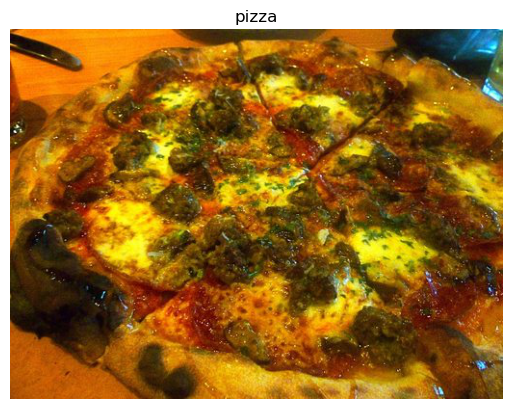

In [48]:
### Visulize the data using matplotlib

import matplotlib.pyplot as plt

plt.imshow(img)
plt.title(class_names)
plt.axis(False);


### Transforming data

Before using the image with PyTorch:
1. Turn target data into tensors 
2. Turn it into a `torch.utils.data.Dataset` and `torch.utils.data.DataLoader`, we'll call these Dataset and DataLoader

In [75]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

In [69]:
# Write a transformer to convert images
data_transform = transforms.Compose([
    
    #Resize the image to (64, 64)
    transforms.Resize((64, 64)),
    
    #Flip the image horizontally
    transforms.RandomHorizontalFlip(p=0.25),
    transforms.RandomVerticalFlip(p=0.25),
    
    #Convert the image to a tensor
    transforms.ToTensor()
    ])



<Figure size 1000x700 with 0 Axes>

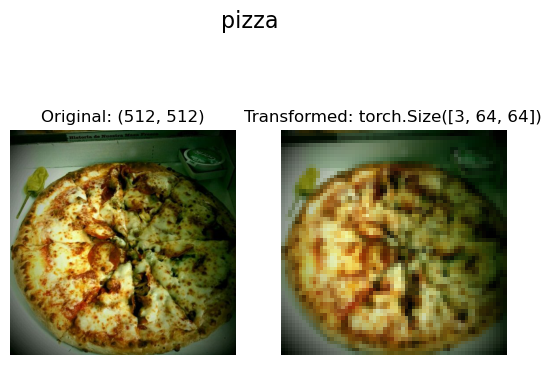

<Figure size 1000x700 with 0 Axes>

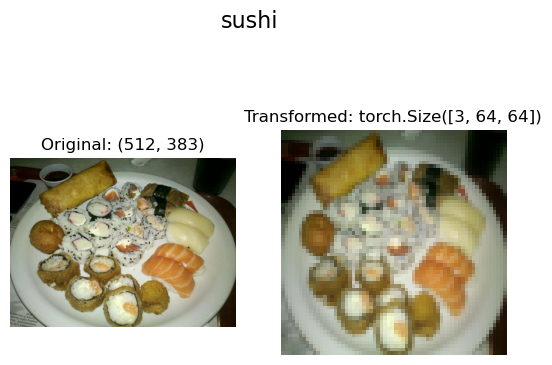

<Figure size 1000x700 with 0 Axes>

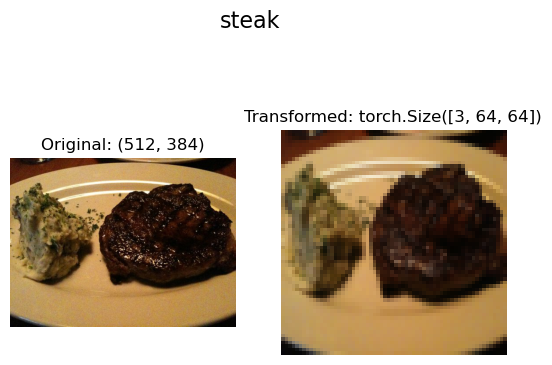

In [73]:
import random
import torch
from PIL import Image
import glob
def plot_transformed_image(image, transform, n=3, seed=None):
    
    '''
    Selects random images from the path of images and loads and transforms them and  
    plot the transformed images
    
    Args:
    image (PIL image): The image to transform
    transform (transform): The image transform
    n (int): The number of images to plot
    seed (int): The random seed to use
    
    Returns:
    None
    '''
    
    if seed:
        random.seed(seed)
    
    random_image_paths = random.sample(image_paths, n)
    
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            plt.figure(figsize=(10, 7))
            fig, axis = plt.subplots(1, 2)
            axis[0].imshow(f)
            axis[0].set_title(f"Original: {f.size}")
            axis[0].axis(False)
            
            # Transform the image and plot both the original and transformed image
            transformed_image = transform(f)
            axis[1].imshow(transformed_image.permute(1, 2, 0))
            axis[1].set_title(f"Transformed: {transformed_image.shape}")
            axis[1].axis(False)
            
            fig.suptitle(image_path.parent.stem, fontsize=16)
    
    
plot_transformed_image(img, 
                        data_transform,
                        n=3,
                        )

### Option 1: Loading image data from `ImageFolder`

We can load image classification data using `torchvision.datasets.ImageFolder` by passing it the root directory of our data. It assumes the data is organized in the following way:
* root/dog/xxx.png
* root/dog/xxy.png
* root/dog/xxz.png
* root/cat/123.png
* root/cat/nsdf3.png
* root/cat/asd932_.png

In [77]:
# Use the Image Folder to create datasets
from cgi import test
from torchvision import datasets

# Create the training dataset

train_dataset = datasets.ImageFolder(root= train_dir, 
                                    transform=data_transform,
                                    target_transform=None)

test_dataset = datasets.ImageFolder(root= test_dir, 
                                    transform=data_transform)

test_dataset,  train_dataset

C:\Users\jakev\AppData\Local\Temp\ipykernel_38736\4056895025.py:2: DeprecationWarning: 'cgi' is deprecated and slated for removal in Python 3.13
  from cgi import test


(Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.25)
                RandomVerticalFlip(p=0.25)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.25)
                RandomVerticalFlip(p=0.25)
                ToTensor()
            ))

In [78]:
# Get the class names as a list
class_names = train_dataset.classes
class_names

['pizza', 'steak', 'sushi']

In [79]:
class_dict = train_dataset.class_to_idx

In [80]:
# Get the length of the training dataset and the test dataset
len(train_dataset), len(test_dataset)

(225, 75)